## Import Libraries

In [2]:
!pip install liac-arff

  Created wheel for liac-arff: filename=liac_arff-2.5.0-py3-none-any.whl size=11732 sha256=468a82f7031e348b06473db4492117342d50d42f08499a5803261908d0abc2ef
  Stored in directory: /root/.cache/pip/wheels/1f/0f/15/332ca86cbebf25ddf98518caaf887945fbe1712b97a0f2493b
Successfully built liac-arff


In [33]:
import pandas as pd
import numpy as np
import arff
from matplotlib import pyplot as plt
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, ConfusionMatrixDisplay
import requests

## Import Data

In [4]:
# get data from online
training_arff = requests.get('https://raw.githubusercontent.com/juwon0502/MIS-373-Predictive-Analytics/master/datasets/bank-training.arff')
testing_arff = requests.get('https://raw.githubusercontent.com/juwon0502/MIS-373-Predictive-Analytics/master/datasets/bank-NewCustomers.arff')

# read as arff file
training_arff = arff.load(training_arff.text)
testing_arff = arff.load(testing_arff.text)
col_val = [attribute[0] for attribute in training_arff['attributes']]

# transform arff file into pandas dataframe
training_df = pd.DataFrame(training_arff['data'], columns = col_val)
testing_df = pd.DataFrame(testing_arff['data'], columns = col_val)
meta = training_arff['attributes']

def clean_df(df):
  cols = list(df.columns)
  for col in cols:
    try:
      df = df.replace({col: {'YES': True, 'NO': False}})
    except:
      pass
    pass
  return df

training_df = clean_df(training_df)
training_df_dummy = pd.get_dummies(training_df)
testing_df_dummy = pd.get_dummies(clean_df(testing_df))

## Sample Model

In [5]:
X = training_df_dummy.drop(columns = ['pep'])
y = training_df_dummy.pep
model = DecisionTreeClassifier(criterion = 'entropy', max_depth = 5).fit(X, y)

## Classification Accuracy Rate

In [6]:
# Using training data

prediction = model.predict(X)
print(accuracy_score(y, prediction))

0.8683333333333333


In [7]:
# Uncomment to see prediction and true values

# print()
# print("Num. Prediction, True, Correct")
# for i in range(len(prediction)):
#   print(f"{i}. {prediction[i]}, {y[i]}, {prediction[i] == y[i]}")

In [8]:
# Using out of sample data

X_test = testing_df_dummy.drop(columns = ['pep'])
y_test = testing_df_dummy.pep
test_prediction = model.predict(X_test)
print(accuracy_score(y_test, test_prediction))

0.715


## Train Test Split

Model A is the whole data set.
Model B is "training split" (2/3 of data set)

In [9]:
X_A = training_df_dummy.drop(columns = ['pep'])
y_A = training_df_dummy.pep
X_B_train, X_B_test, y_B_train, y_B_test = train_test_split(X_A, y_A, test_size=0.33)

In [10]:
A_model = DecisionTreeClassifier(criterion='entropy', max_depth=5).fit(X_A, y_A)
B_model = DecisionTreeClassifier(criterion='entropy', max_depth=5).fit(X_B_train, y_B_train)

print("Model A:", accuracy_score(y_A, A_model.predict(X_A)))
print("Model B:", accuracy_score(y_B_test, B_model.predict(X_B_test)))

Model A: 0.8683333333333333
Model B: 0.7828282828282829


## Cross Validation

In [13]:
scores = cross_val_score(model, X, y, cv = 200)
print(scores.mean())

0.8433333333333334


## Pruning

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

for depth in reversed(range(2,11)):
  temp_model = DecisionTreeClassifier(criterion = 'entropy', max_depth=depth).fit(X_train, y_train)
  print(f"{depth}: Training: {accuracy_score(y_test, temp_model.predict(X_test))}, CV: {(cross_val_score(temp_model, X, y, cv = 10)).mean()}")

10: Training: 0.8585858585858586, CV: 0.8316666666666668
9: Training: 0.8888888888888888, CV: 0.8316666666666668
8: Training: 0.8787878787878788, CV: 0.8466666666666667
7: Training: 0.8636363636363636, CV: 0.8633333333333335
6: Training: 0.8434343434343434, CV: 0.8666666666666666
5: Training: 0.8434343434343434, CV: 0.8433333333333334
4: Training: 0.8434343434343434, CV: 0.8283333333333334
3: Training: 0.702020202020202, CV: 0.7366666666666666
2: Training: 0.6464646464646465, CV: 0.5933333333333334


In [27]:
min_leaves_model = DecisionTreeClassifier(criterion = 'entropy', min_samples_leaf = 5).fit(X, y)
print(accuracy_score(y, min_leaves_model.predict(X)))

0.92


In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

for leaves in reversed(range(2,11)):
  temp_model = DecisionTreeClassifier(criterion = 'entropy', min_samples_leaf=leaves).fit(X_train, y_train)
  print(f"{leaves}: Training: {accuracy_score(y_test, temp_model.predict(X_test))}, CV: {(cross_val_score(temp_model, X, y, cv = 10)).mean()}")

10: Training: 0.803030303030303, CV: 0.8766666666666666
9: Training: 0.8383838383838383, CV: 0.875
8: Training: 0.8333333333333334, CV: 0.8800000000000001
7: Training: 0.8333333333333334, CV: 0.86
6: Training: 0.8535353535353535, CV: 0.8633333333333333
5: Training: 0.8383838383838383, CV: 0.865
4: Training: 0.8181818181818182, CV: 0.845
3: Training: 0.7878787878787878, CV: 0.85
2: Training: 0.803030303030303, CV: 0.8466666666666667


## Precision/Recall

In [42]:
y_test = testing_df_dummy.pep
X_test = testing_df_dummy.drop(columns=['pep'])

model = DecisionTreeClassifier(criterion = 'entropy', min_samples_leaf = 7, max_depth = 6).fit(X_train, y_train)

predictions = model.predict(X_test)

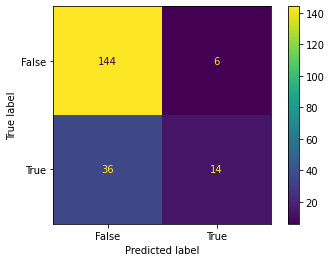

In [43]:
cm = confusion_matrix(y_test, predictions, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()

In [45]:
print("Precision:", precision_score(y_test, predictions))
print("Recall:", recall_score(y_test, predictions))

Precision: 0.7
Recall: 0.28


## Cost Sensitivity


## Information Gain/Mutual Informaiton

In [ ]:
mi = list(mutual_info_classif(training_df_dummy.drop(columns = ['pep']), training_df_dummy.pep))
for m in mi:
  print(m)

0.007366812743496043
0.0018936945902052749
0.0
0.06965876253465408
0.0
0.016229845028548073
0.0
0.026581900724257146
0.012365151851355005
0.014765620930978551
0.034349097780153715
0.0
0.0
0.0016275168012200858
